In [2]:
#Set up the environment
library(tidyverse)
library(reshape2)
library(data.table)

In [3]:
#First, load in the ccle variants and format the dataset so that it looks nice
setwd("../data")
ccle.variant.calls = read.table("snps.in.all.avana.guides.vcf.gz", sep = "\t") %>%
filter(V7 %in% "PASS") %>%
select(-V1, -V2, -V4, -V5, -V6, -V7, -V8, -V9)

#Reformat the genotyping data
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub(":..*", "", x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|0", 0, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("0\\|1", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|0", 1, x) })
ccle.variant.calls[2:ncol(ccle.variant.calls)] = apply(ccle.variant.calls[2:ncol(ccle.variant.calls)], 2, function(x){gsub("1\\|1", 2, x) })

#Fix the SNP column
ccle.variant.calls = ccle.variant.calls %>%
separate(V3, sep = ":", into = c("chr", "pos", "ref", "alt"))

#Then fix the names on that dataset
#First extract the sample names from the vcf file, then load them into R
setwd("../data")
sample.names = read.table("ccle.vcf.sample.names.txt", sep = "\t") %>%
pull(1)

ccle.variant.calls = ccle.variant.calls
colnames(ccle.variant.calls) = c("chr", "pos", "ref", "alt", sample.names)

In [4]:
#First, load in the guide map so that we can figure out which guides are on the plus or minus strand
setwd("../data")
guide.map = read.table("21q4_Achilles_guide_map.csv", header = T, sep = ",") %>%
select(sgrna, genome_alignment) %>%
mutate(genome_alignment = gsub("..*_", "", genome_alignment)) %>%
rename("strand" = genome_alignment) %>%
distinct(sgrna, .keep_all = TRUE)

#Load in the Avana bed file to get positions for the ancestry-associated guides
#Also add the annotation information from guides.to.keep to the avana.bed matrix
#Also flip the start and end positions if the sgrna is on the minus strand
setwd("../data")
avana.bed <- read.table('Avana14_filtering.bed', sep = "\t", header = F) %>%
rename("chr" = 1, "start" = 2, "end" = 3, "sgrna" = 4) %>%
inner_join(guide.map, by = "sgrna") %>%
mutate("true_start" = ifelse(strand %in% "+", start, end)) %>%
mutate("true_end" = ifelse(strand %in% "+", end, start))%>% #This line and the line above will create two new columns to flip the start and end if the sgrna is on the minus strand
select(chr, true_start, true_end, sgrna) %>%
rename("start" = true_start) %>%
rename("end" = true_end)

In [5]:
#For each guide in avana.bed calculate if there is a snp in the guide, then calculate the position of that SNP
snp.in.guide.list = NULL
for(i in 1:nrow(avana.bed)){
  
    #get information for the guide of interest
    guide.start = avana.bed$start[i] %>% as.numeric() #get the position of the guide
    guide.chrom = avana.bed$chr[i] #get the chromosome that the guide is on
    sgrna.barcode = avana.bed$sgrna[i] #get the barcode sequence
    
    #subset out subset.ccle.snps so that it only includes snps on that chromsome
    subset.to.chr = ccle.variant.calls %>% filter(chr %in% guide.chrom)
    
    #now calculate the differential and add it to the list outside of the loop
    snp.position = guide.start - as.numeric(subset.to.chr$pos)
    snp.in.guide.list[[i]] = snp.position
}
names(snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [6]:
#Assign the SNP ID as names for each vector

annotated.snp.in.guide.list = NULL
for(i in 1:length(snp.in.guide.list)){
        
    chromosome = avana.bed$chr[i] #get the chromosome which that guide targets
    
    #Now get a vector of snp positions and annotate the relative snp position vector with that information
    vector.to.annotate = snp.in.guide.list[[i]] #grab the vector that we need to annotate in this loop
    snp.vector = ccle.variant.calls %>% filter(chr %in% chromosome) %>% mutate(snp = paste(chr, ":", pos, ":", ref, ":", alt, sep = "")) %>% pull(snp) #make a vector that contains the snp information
    names(vector.to.annotate) = snp.vector #now apply that annotation to the vector of snp positions
    
    #Report the information outside of the loop
    annotated.snp.in.guide.list[[i]] = vector.to.annotate
    
}

names(annotated.snp.in.guide.list) = avana.bed$sgrna #Then name the list with the corresponding sgrna sequence

In [7]:
#Go through the list and remove the SNPs that don't map to a sgrna
pruned.snp.list = annotated.snp.in.guide.list %>%
lapply(function(x){
    vector = abs(x)
    val.to.return = vector[vector %in% 0:22]
    return(val.to.return)
}) %>% compact(1) #compact is part of the purrr package and will remove guides that don't have a SNP

In [8]:
#Now let's go through and create a nice data frame from this list.

snp.in.guide.df = NULL
for(i in 1:length(pruned.snp.list)){
    
   sgrna = pruned.snp.list[[i]] #this is a vector (normally length = 1, sometimes more with all of the snps that map to a vector)
   
    #If there is only one snp that maps to that sgrna, simply construct the vector and add it to the data frame
    #If there is more than one snp, then we need to get a little more fancy and construct a data frame first
    if(length(sgrna) == 1){
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        snp = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        vector.to.add = c(sgrna, snp, position) #Make a vector of values to add to the data frame
        snp.in.guide.df = rbind(snp.in.guide.df, vector.to.add) %>% data.frame() %>% #Then add that vector to the data frame
        rename("sgrna" = 1, "snp" = 2, "position" = 3)  
    } else {
        sgrna = names(pruned.snp.list[i]) #get the sgrna for this iteration of the loop
        sgrna.vector = rep(sgrna, length(pruned.snp.list[[i]])) #get a vector that contains the sgrna now, length = #snps
        snp.vector = names(pruned.snp.list[[i]]) #get the snp code for this iteration of the loop
        position.vector = pruned.snp.list[[i]] #Get the relative position of the SNP on the guide for this iteration of the loop
        df.to.add = cbind(sgrna.vector, snp.vector, position.vector) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3) #bind it all into a data frame
        snp.in.guide.df = rbind(snp.in.guide.df, df.to.add) %>% data.frame() %>%
        rename("sgrna" = 1, "snp" = 2, "position" = 3)
 }
}

row.names(snp.in.guide.df) = NULL #remove the row names on the new df since they are useless

In [9]:
#Write the matrix so we don't need to re-run all of that code
setwd("../output")
write.table(snp.in.guide.df, "supplemental_figure_7_snp_in_guide_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

In [10]:
#Collapse everything to a clean sgRNA/cell line matrix
processed.genotype.matrix = ccle.variant.calls %>%
mutate("snp" = paste(chr, ":", pos, ":", ref, ":", alt, sep = ""), .before = chr) %>%
select(-chr, -pos, -ref, -alt) %>%
mutate(snp = plyr::mapvalues(snp, from = snp.in.guide.df$snp, to = snp.in.guide.df$sgrna, warn_missing = FALSE)) %>%
mutate_at(vars(2:ncol(.)), as.numeric) %>%
aggregate(. ~ snp, FUN = sum)

In [11]:
#Load in the sgrna-to-gene mapping file
setwd("../data")
sgrna.mapping.file = read.table("21q4_Achilles_guide_map.csv", header = T, sep = ",") %>%
select(sgrna, gene) %>%
mutate(gene = word(gene, 1))

In [12]:
#Now replace the sgrna with the gene name
processed.gene.snp.matrix = processed.genotype.matrix %>%
mutate(snp = plyr::mapvalues(from = sgrna.mapping.file$sgrna, to = sgrna.mapping.file$gene, snp, warn_missing = FALSE)) %>%
aggregate(. ~ snp, FUN = sum) %>%
rename("gene" = snp)

In [13]:
#Load in the chronos data and format it
setwd("../data")
broad.chronos.scores = fread('22q1_crispr_gene_effect.csv', sep = ",", header = T, check.names = FALSE) %>%
setNames(word(names(.), 1)) 

In [14]:
#Figure out which cell lines are shared between the chronos dataset and the genotyping dataset
chronos.cell.lines = broad.chronos.scores %>% pull(DepMap_ID)
genotyping.cell.lines = colnames(processed.gene.snp.matrix)[2:ncol(processed.gene.snp.matrix)]
intersecting.lines = intersect(chronos.cell.lines, genotyping.cell.lines)

#Calculate the intersecting genes between the two datasets
genotyping.genes = processed.gene.snp.matrix$gene
chronos.genes = colnames(broad.chronos.scores)[2:ncol(broad.chronos.scores)]
intersecting.genes = intersect(genotyping.genes, chronos.genes)


In [24]:
#filter both the chronos and the snp.gene.matrix so that they only include the intersecting lines andgenes
filtered.gene.snp.matrix = processed.gene.snp.matrix %>%
select(gene, all_of(intersecting.lines)) %>%
filter(gene %in% intersecting.genes)

filtered.chronos.scores = broad.chronos.scores %>%
filter(DepMap_ID %in% intersecting.lines) %>%
select(DepMap_ID, all_of(intersecting.genes))

In [16]:
#Get two lists of cell lines with/without snps
#Get a vector that has all of the cell line names
cell.line.name.vector = colnames(filtered.gene.snp.matrix)[2:ncol(filtered.gene.snp.matrix)]

#For each gene, grab all cell lines with a snp in at least one of the guides, store as a list.
lines.with.snp = filtered.gene.snp.matrix %>%
select(-gene) %>%
apply(1, function(x){
    line.index = which(x > 0) #get the position index of all lines with snps
    line.name = cell.line.name.vector[line.index] #Get a vector with all of the cell line names
    return(line.name) #Return the cell line names to outside of the apply loop
})


#For each gene, grab all cell lines with a snp in none of the guides, store as a list.
lines.without.snp = filtered.gene.snp.matrix %>%
select(-gene) %>%
apply(1, function(x){
    line.index = which(x == 0) #get the position index of all lines with snps
    line.name = cell.line.name.vector[line.index] #Get a vector with all of the cell line names
    return(line.name) #Return the cell line names to outside of the apply loop
})

#Assign the names
names(lines.with.snp) = filtered.gene.snp.matrix$gene
names(lines.without.snp) = filtered.gene.snp.matrix$gene

In [17]:
#Get a list of chronos scores for all genes with the snp and without the snp
#This should take about 30 minutes to run
#First, with the snp
chronos.with.snp = NULL
for(i in 1:length(lines.with.snp)){
    
    #get the cell line names that we want to grab
    cell.lines.to.grab = lines.with.snp[[i]]
    
    #filter the chronos score dataset to only include those cell lines
    chronos.scores = filtered.chronos.scores %>% 
    filter(DepMap_ID %in% all_of(cell.lines.to.grab)) %>%
    select(-DepMap_ID) %>%
    pull(all_of(i))
    
    #Add the chronos scores to the list
    chronos.with.snp[[i]] = chronos.scores
}



#Now, without the snp
chronos.without.snp = NULL
for(i in 1:length(lines.without.snp)){
    
    #get the cell line names that we want to grab
    cell.lines.to.grab = lines.without.snp[[i]]
    
    #filter the chronos score dataset to only include those cell lines
    chronos.scores = filtered.chronos.scores %>% 
    filter(DepMap_ID %in% all_of(cell.lines.to.grab)) %>%
    select(-DepMap_ID) %>%
    pull(all_of(i))
    
    #Add the chronos scores to the list
    chronos.without.snp[[i]] = chronos.scores
}

In [18]:
###FINALLY we are ready to calculate p-values between the two classes of samples
pval.vector = NULL
for(i in 1:length(chronos.with.snp)){
    
    with.snp.values = chronos.with.snp[[i]] #extract the values for cell lines with the snp
    without.snp.values = chronos.without.snp[[i]] #extract the values for cell lines without the snp
    
    #Calculate the p-value
    if(length(with.snp.values) >= 3 & length(without.snp.values) >= 3) {
        pval = wilcox.test(with.snp.values, without.snp.values, alternative = "two.sided")$p.value
    } else { pval = 1 }
    
    #Return everything outside of the vector
    pval.vector[i] = pval
  
}

In [19]:
#Calculate the differential between the two lists
chronos.with.snp.mean = chronos.with.snp %>% lapply(mean) %>% unlist()
chronos.without.snp.mean = chronos.without.snp %>% lapply(mean) %>% unlist()
differential.vector = chronos.with.snp.mean - chronos.without.snp.mean

In [20]:
#Construct the final dataset
dataset.for.plotting = cbind(processed.gene.snp.matrix$gene, differential.vector, pval.vector) %>%
data.frame() %>%
rename("gene" = 1, "differential" = 2, "pval" = 3) %>%
mutate(differential = as.numeric(differential)) %>%
mutate(pval = as.numeric(pval)) %>%
mutate("fdr" = p.adjust(pval, method = "BH", n = length(pval))) %>%
mutate("sig_flag" = ifelse(fdr < 0.05 & abs(differential) > 0.2, "significant", "not_sigificant"))

Warning message in cbind(processed.gene.snp.matrix$gene, differential.vector, pval.vector):
“number of rows of result is not a multiple of vector length (arg 2)”


In [21]:
#Calculate the total number of significant genes
num.sig.genes = dataset.for.plotting %>% filter(sig_flag %in% "significant") %>% nrow()
print(paste("the total number of sig genes is", num.sig.genes))


num.sig.genes.by.fdr = dataset.for.plotting %>% filter(fdr < 0.05) %>% nrow()
print(paste("the total number of sig genes by fdr is", num.sig.genes.by.fdr))

[1] "the total number of sig genes is 47"
[1] "the total number of sig genes by fdr is 793"


In [22]:
#Write df.for.plotting so we don't need to re-make it
setwd("../output")
write.table(dataset.for.plotting, "supplemental_figure_7_df.txt", sep = "\t", col.names = TRUE, row.names = FALSE, quote = FALSE)

Warning message:
“Removed 102 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 102 rows containing missing values or values outside the scale range
(`geom_point()`).”


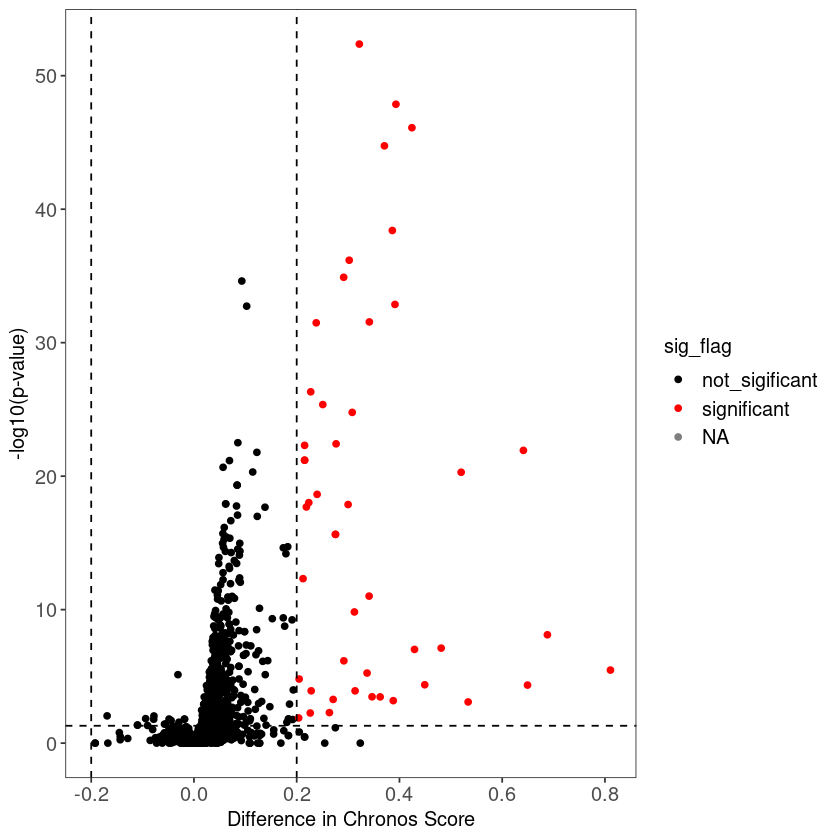

In [23]:
#Plot the plot
dataset.for.plotting %>%
ggplot(aes(x = differential, y = -log10(fdr), color = sig_flag)) +
geom_point() +
geom_hline(yintercept = -log10(0.05), linetype = 2) +
geom_vline(xintercept = 0.2, linetype = 2) +
geom_vline(xintercept = -0.2, linetype = 2) +
theme_bw() +

scale_color_manual(values = c("black", "red")) +

theme(
panel.grid.major = element_blank(),
panel.grid.minor = element_blank(), 
) +

theme(
axis.title.x = element_text(color = "black", size = 12),
axis.title.y = element_text(color = "black", size = 12)
) +

theme(
axis.text = element_text(size = 12),
axis.title = element_text(size = 12)
) +

theme(
legend.title = element_text(size = 12),
legend.text = element_text(size = 12)
) +

scale_x_continuous(breaks = seq(-0.4, 0.8, by = 0.2)) +

ylab("-log10(p-value)") +
xlab("Difference in Chronos Score")

#Export it to the google bucket
setwd('../output')
ggsave("supplemental_figure_7.pdf", width = 5, height = 3)